<a href="https://colab.research.google.com/github/daria-lpch/creating_eeg_database/blob/main/Find_EEG_patients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Для работы скопируйте себе на гугл диск, добавьте файлы на диск, пропишите путь к папке на диске, укажите корректное имя файла

In [ ]:
#!pip install transliterate

# Подключим используемые библиотеки

In [ ]:

import csv

#import transliterate
#from transliterate import translit

import numpy as np
from scipy import signal
import scipy
from sympy import *
from bokeh.models.plots import Legend
from bokeh.models import Span

from bokeh.plotting import figure, output_file, show
import bokeh.io
from bokeh.resources import INLINE
bokeh.io.output_notebook(INLINE)

# Подключение к гугл диску

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/EEG_analytics/


/content/drive/My Drive/EEG_analytics


# Получение сырых данных

Имена файлов

In [ ]:
latin_names_spreadsheet = 'Patients_who_has Eeg.csv'
russian_names_spreadsheet = 'Patients_with_MKB.csv'
# чтобы посмотреть содержимое столбца фамилия из файла на латинице- расскоментируйте блок ниже
"""
with open(latin_names_spreadsheet, 'r', newline='') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        print(row['Column1']) # Access data by header name
"""

# c записями на латинице всё хорошо  - фамилия, имя и отчество - это отдельные колонки
# чтобы посмотреть содержимое столбца с ФИО из файла на русском- расскоментируйте блок ниже

"""
with open(russian_names_spreadsheet, 'r', newline='') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        print(row['Column1']) # Access data by header name
"""
# а c записями на русском не  всё хорошо  - фамилия, имя и отчество -  в одной колонке.

"\nwith open(russian_names_spreadsheet, 'r', newline='') as csv_file:\n    csv_reader = csv.DictReader(csv_file)\n    for row in csv_reader:\n        print(row['Column1']) # Access data by header name\n"

Подготовим свой транслитератор тк из библиотеки транслирует не так

In [ ]:
def transliterate_russian_name(name):
    """
    Базовая функция транслитерации для русскоязычных имен.
    """
    cyrillic_to_latin_map = {
        'а': 'a', 'б': 'b', 'в': 'v', 'г': 'g', 'д': 'd', 'е': 'e', 'ё': 'e', 'ж': 'zh',
        'з': 'z', 'и': 'i', 'й': 'i', 'к': 'k', 'л': 'l', 'м': 'm', 'н': 'n', 'о': 'o',
        'п': 'p', 'р': 'r', 'с': 's', 'т': 't', 'у': 'u', 'ф': 'f', 'х': 'kh', 'ц': 'ts',
        'ч': 'ch', 'ш': 'sh', 'щ': 'shch', 'ъ': '', 'ы': 'y', 'ь': '', 'э': 'e', 'ю': 'yu',
        'я': 'ya',
        'А': 'A', 'Б': 'B', 'В': 'V', 'Г': 'G', 'Д': 'D', 'Е': 'E', 'Ё': 'E', 'Ж': 'Zh',
        'З': 'Z', 'И': 'I', 'Й': 'I', 'К': 'K', 'Л': 'L', 'М': 'M', 'Н': 'N', 'О': 'O',
        'П': 'P', 'Р': 'R', 'С': 'S', 'Т': 'T', 'У': 'U', 'Ф': 'F', 'Х': 'Kh', 'Ц': 'Ts',
        'Ч': 'Ch', 'Ш': 'Sh', 'Щ': 'Shch', 'Ъ': '', 'Ы': 'Y', 'Ь': '', 'Э': 'E', 'Ю': 'Yu',
        'Я': 'Ya'
    }

    translit_name = "".join(cyrillic_to_latin_map.get(char, char) for char in name)
    return translit_name

In [ ]:
# предобработаем  русский файл - разобьем  ФИО на три колонки и тут же транслитерируем
russian_name_with_mkb_list =[]
english_name_list = []
with open(russian_names_spreadsheet, 'r', newline='') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        str_fio = row['Column1']
        str_fio_translated = transliterate_russian_name(str_fio)
        str_mkb = row['Column2']
        russian_name_with_mkb_list .append ([str_fio_translated.split(),str_mkb])

#сделаем такой же из английских, для красоты
with open(latin_names_spreadsheet, 'r', newline='') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        str_surname = row['Column1']
        str_name = row['Column2']
        str_secondname = row['Column3']
        english_name_list.append([str_surname , str_name,str_secondname])


#print(russian_name_with_mkb_list)
#print(english_name_list)

#Нашла следующие ошибки в  изначальном файле с пациентами у которых есть  ЭЭГ

1.   Неправильная транслитерация Ульяна как Uliana
2.   11 пациентов без отчеств, Имя занеcено в графу отчество





# Так, а теперь должен быть поиск. Искать будем пациентов из списка с МкБ в списке с ЭЭГ

In [ ]:
matching_patients = []

# Iterate through the Russian list
for russian_patient in russian_name_with_mkb_list:
    russian_fio = russian_patient[0]  # ['Surname', 'Name', 'Patronymic']
    russian_mkb = russian_patient[1]

    # Iterate through the English list
    for english_patient in english_name_list:
        english_fio = english_patient  # ['Surname', 'Name', 'Patronymic']
  #  в базе есть ошибки- отчества введены не полностью. поэтому сначала сравним без отчеств
        if russian_fio[0] == english_fio[0] and \
           russian_fio[1] == english_fio[1]:
           matching_patients.append((english_fio, russian_mkb))
# Print the matching patients and their MKB codes
#print("Matching Patients (Name, Surname, Patronymic) and MKB Code:")
#for patient_info, mkb_code in matching_patients:
    #print(f"{' '.join(patient_info)}: {mkb_code}")

In [ ]:
#уберем дубликаты склеив ФИО с мкб
merged_fio_list=[]
for patient_info, mkb_code in matching_patients:
    merged_fio_list.append(f"{' '.join(patient_info)} {mkb_code}")
unique_fio_set = set(merged_fio_list)
unique_list = list(unique_fio_set)
#print(unique_list)
#теперь расклеим обратно
unique_english_name_list_with_mkb = []
for row in unique_list:
    unique_english_name_list_with_mkb.append (row.split())
print(unique_english_name_list_with_mkb)

[['Dudin', 'Yaroslav', 'Evgenevich', 'F70.0'], ['Neklyudov', 'Ivan', 'Ivanovich', 'F06.6'], ['Vozchikov', 'Lev', 'Georgievich', 'F06.6'], ['Nigmatullin', 'Ruslan', 'Albertovic', 'F06.6'], ['Pakulin', 'Lev', 'Stanislavovich', 'F06.6'], ['Turov', 'Vladimir', 'Evgenevich', 'F80.9'], ['Sofronova', 'Ekaterina', 'Evgenevna', 'F06.6'], ['Izmestev', 'Ilya', 'Vitalevich', 'F06.6'], ['Zubova', 'Sofiya', 'Evgenevna', 'F06.6'], ['Andreeva', 'Aglaya', 'Vadimovna', 'F90'], ['Kazakov', 'Valentin', 'Aleksandrovi', 'F06.6'], ['Klementev', 'Daniil', 'Maksimovich', 'F06.6'], ['Dzyuba', 'Gleb', 'Romanovich', 'G40.9'], ['Smotrina', 'Viktoriya', 'Antonovna', 'F06.6'], ['Ogibenina', 'Elena', 'Sergeevna', 'F06.6'], ['Belkin', 'Vsevolod', 'Sergeevich', 'F06.6'], ['Kosyanenko', 'Bogdan', 'Artemevich', 'F06.6'], ['Filinkova', 'Varvara', 'Ilinichna', 'F06.6'], ['Mosyakina', 'Karina', 'Igorevna', 'F06.8'], ['Chega', 'Maksim', 'Sergeevich', 'F90'], ['Smotrina', 'Viktoriya', 'Antonovna', 'F80.1'], ['Perun', 'Arina',

#Пилим отображение уникальных мкб-кодов

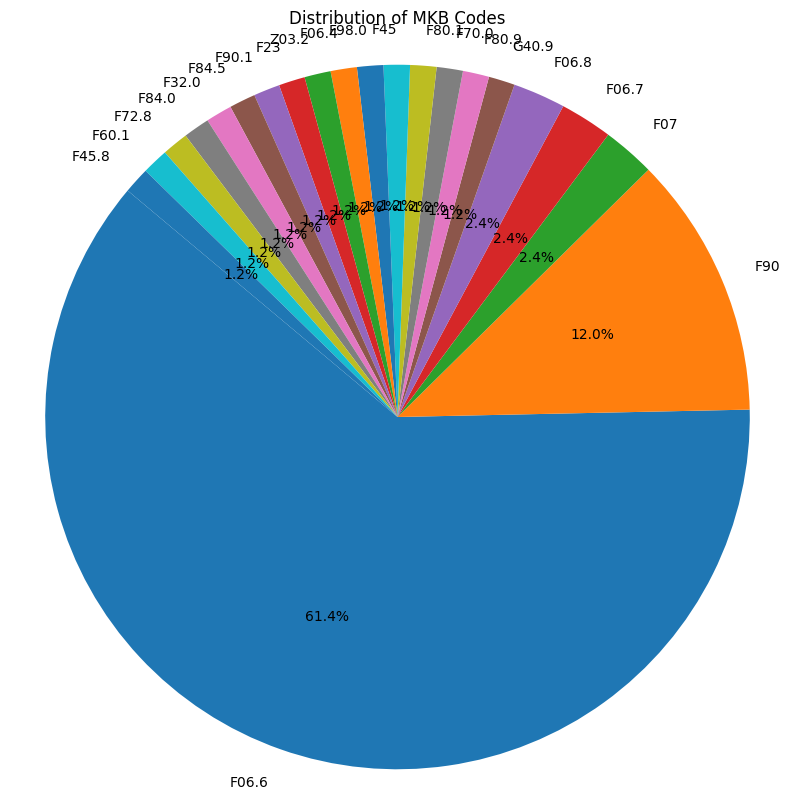

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the list to a pandas DataFrame for easier processing
df_mkb = pd.DataFrame(unique_english_name_list_with_mkb, columns=['Surname', 'Name', 'Patronymic', 'MKB Code'])

# Count the occurrences of each MKB code
mkb_counts = df_mkb['MKB Code'].value_counts()

# Create a pie chart
plt.figure(figsize=(10, 10))
plt.pie(mkb_counts, labels=mkb_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of MKB Codes')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Теперь отобразим с расшифровкой

In [ ]:
mkb_decodes_spreadsheet = 'unique_mkb_decoder.csv'
diagnoses = []
# чтобы посмотреть содержимое столбца фамилия из файла на латинице- расскоментируйте блок ниже
with open(mkb_decodes_spreadsheet, 'r', newline='') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        diagnoses.append (row)
print(diagnoses)


[{'code': 'F06.4', 'расшифровка': 'органическое тревожное расстройство'}, {'code': 'F06.6', 'расшифровка': 'органическое эмоциональное лабильное (астеническое) расстройство;'}, {'code': 'F06.7', 'расшифровка': 'лёгкое когнитивное расстройство'}, {'code': 'F06.8', 'расшифровка': 'другие уточнённые психические расстройства, обусловленные повреждением и дисфункцией головного мозга или соматической болезнью'}, {'code': 'F07', 'расшифровка': 'расстройство личности органической этиологии'}, {'code': 'F23', 'расшифровка': 'острое полиморфное психотическое расстройство без симптомов шизофрении'}, {'code': 'F32.0', 'расшифровка': 'Депрессивный эпизод лёгкой степени'}, {'code': 'F45', 'расшифровка': 'Соматизированное расстройство'}, {'code': 'F45.8', 'расшифровка': 'Другие соматоформные расстройства'}, {'code': 'F60.1', 'расшифровка': 'Шизоидное расстройство личности'}, {'code': 'F70.0', 'расшифровка': 'Умственная отсталость лёгкой степени с указанием на отсутствие или слабую выраженность наруше

In [ ]:
# Create a dictionary from the diagnoses list for easy lookup of annotations by MKB code
mkb_decoder = {d['code']: d['расшифровка'] for d in diagnoses}

# Create a new list with annotations added
unique_english_name_list_with_mkb_annotated = []
for patient_info in unique_english_name_list_with_mkb:
    # Assuming the MKB code is the last element in the list
    mkb_code = patient_info[-1]
    annotation = mkb_decoder.get(mkb_code, 'Unknown') # Get annotation, default to 'Unknown' if not found
    unique_english_name_list_with_mkb_annotated.append(patient_info + [annotation])

# Print the first few entries of the new list to verify
print(unique_english_name_list_with_mkb_annotated[:5])

[['Dudin', 'Yaroslav', 'Evgenevich', 'F70.0', 'Умственная отсталость лёгкой степени с указанием на отсутствие или слабую выраженность нарушения поведения'], ['Neklyudov', 'Ivan', 'Ivanovich', 'F06.6', 'органическое эмоциональное лабильное (астеническое) расстройство;'], ['Vozchikov', 'Lev', 'Georgievich', 'F06.6', 'органическое эмоциональное лабильное (астеническое) расстройство;'], ['Nigmatullin', 'Ruslan', 'Albertovic', 'F06.6', 'органическое эмоциональное лабильное (астеническое) расстройство;'], ['Pakulin', 'Lev', 'Stanislavovich', 'F06.6', 'органическое эмоциональное лабильное (астеническое) расстройство;']]


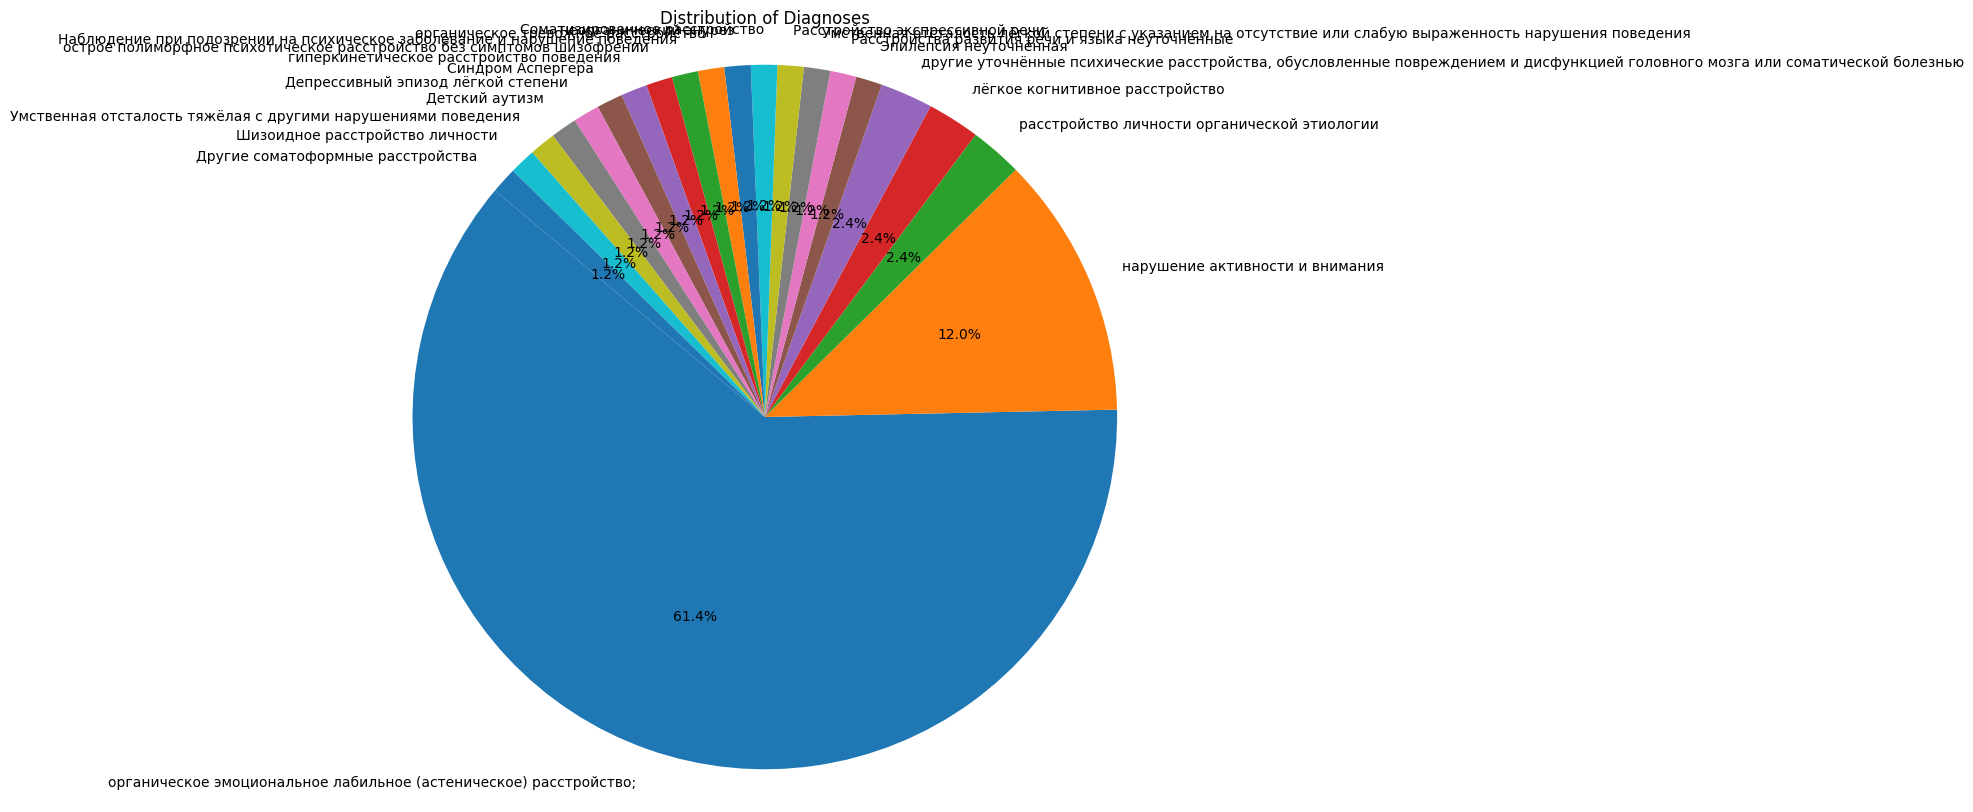

In [ ]:
# Convert the list to a pandas DataFrame for easier processing
df_mkb = pd.DataFrame(unique_english_name_list_with_mkb_annotated, columns=['Surname', 'Name', 'Patronymic', 'MKB Code', 'Diagnose'])

# Count the occurrences of each MKB code
mkb_counts = df_mkb['Diagnose'].value_counts()

# Create a pie chart
plt.figure(figsize=(10, 10))
plt.pie(mkb_counts, labels=mkb_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Diagnoses')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [ ]:
#Еще раз, но поиграем с отображением

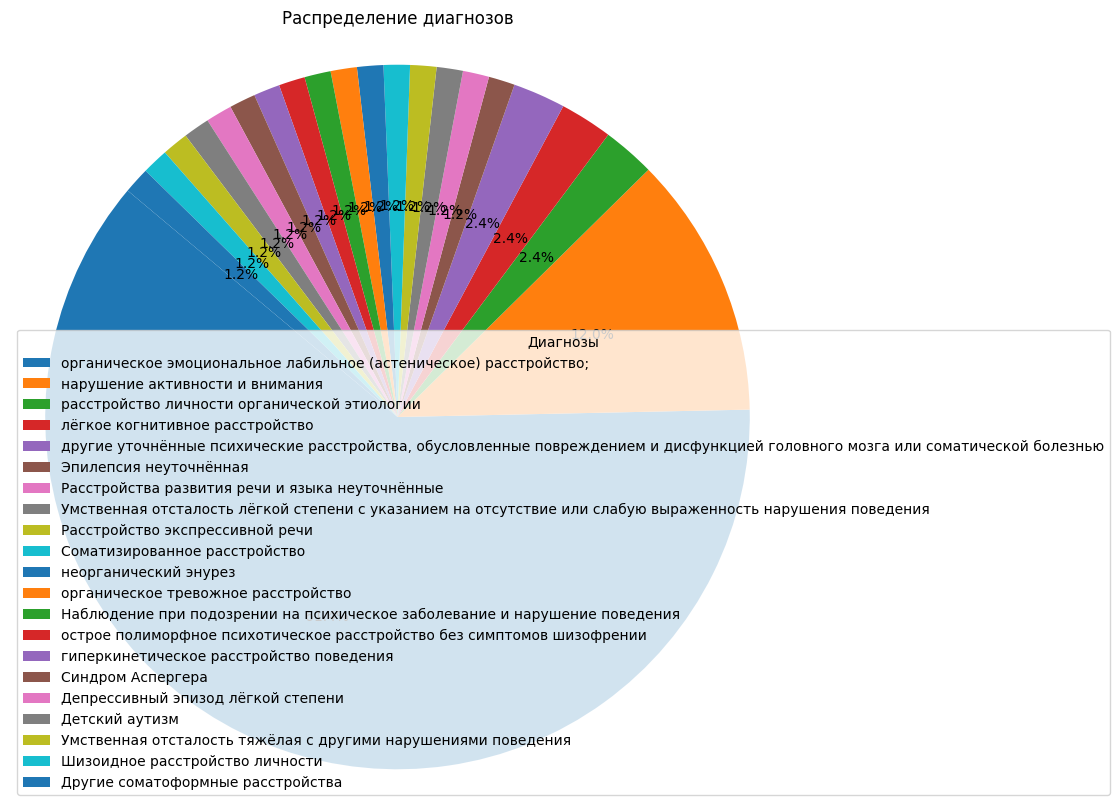

In [ ]:
# Convert the list to a pandas DataFrame for easier processing
df_mkb = pd.DataFrame(unique_english_name_list_with_mkb_annotated, columns=['Surname', 'Name', 'Patronymic', 'MKB Code', 'Diagnose'])

# Count the occurrences of each MKB code
mkb_counts = df_mkb['Diagnose'].value_counts()

# Create a pie chart
plt.figure(figsize=(10, 10))
plt.pie(mkb_counts, labels=None, autopct='%1.1f%%', startangle=140)
plt.title('Распределение диагнозов')

plt.legend(labels=mkb_counts.index, title="Диагнозы")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()